In [75]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### Loading & Analysing Data

In [76]:
responses=pd.read_csv('responses.csv')
responses.head(3)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats


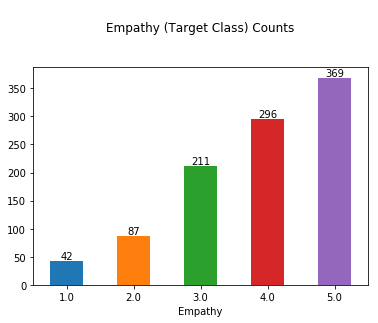

In [77]:
ax = responses.groupby('Empathy').size().plot(kind='bar', title='\nEmpathy (Target Class) Counts\n\n', rot=0)
for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='top',
                xytext=(0, 10),
                textcoords='offset points')

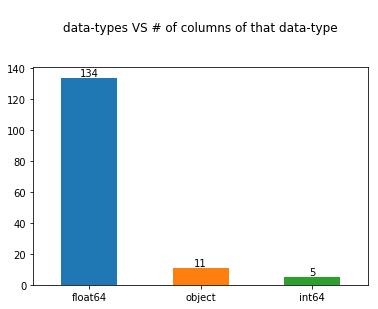

In [78]:
ax = responses.dtypes.value_counts().plot(kind='bar', title='\ndata-types VS # of columns of that data-type\n\n', rot=0)
for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='top',
                xytext=(0, 10),
                textcoords='offset points')

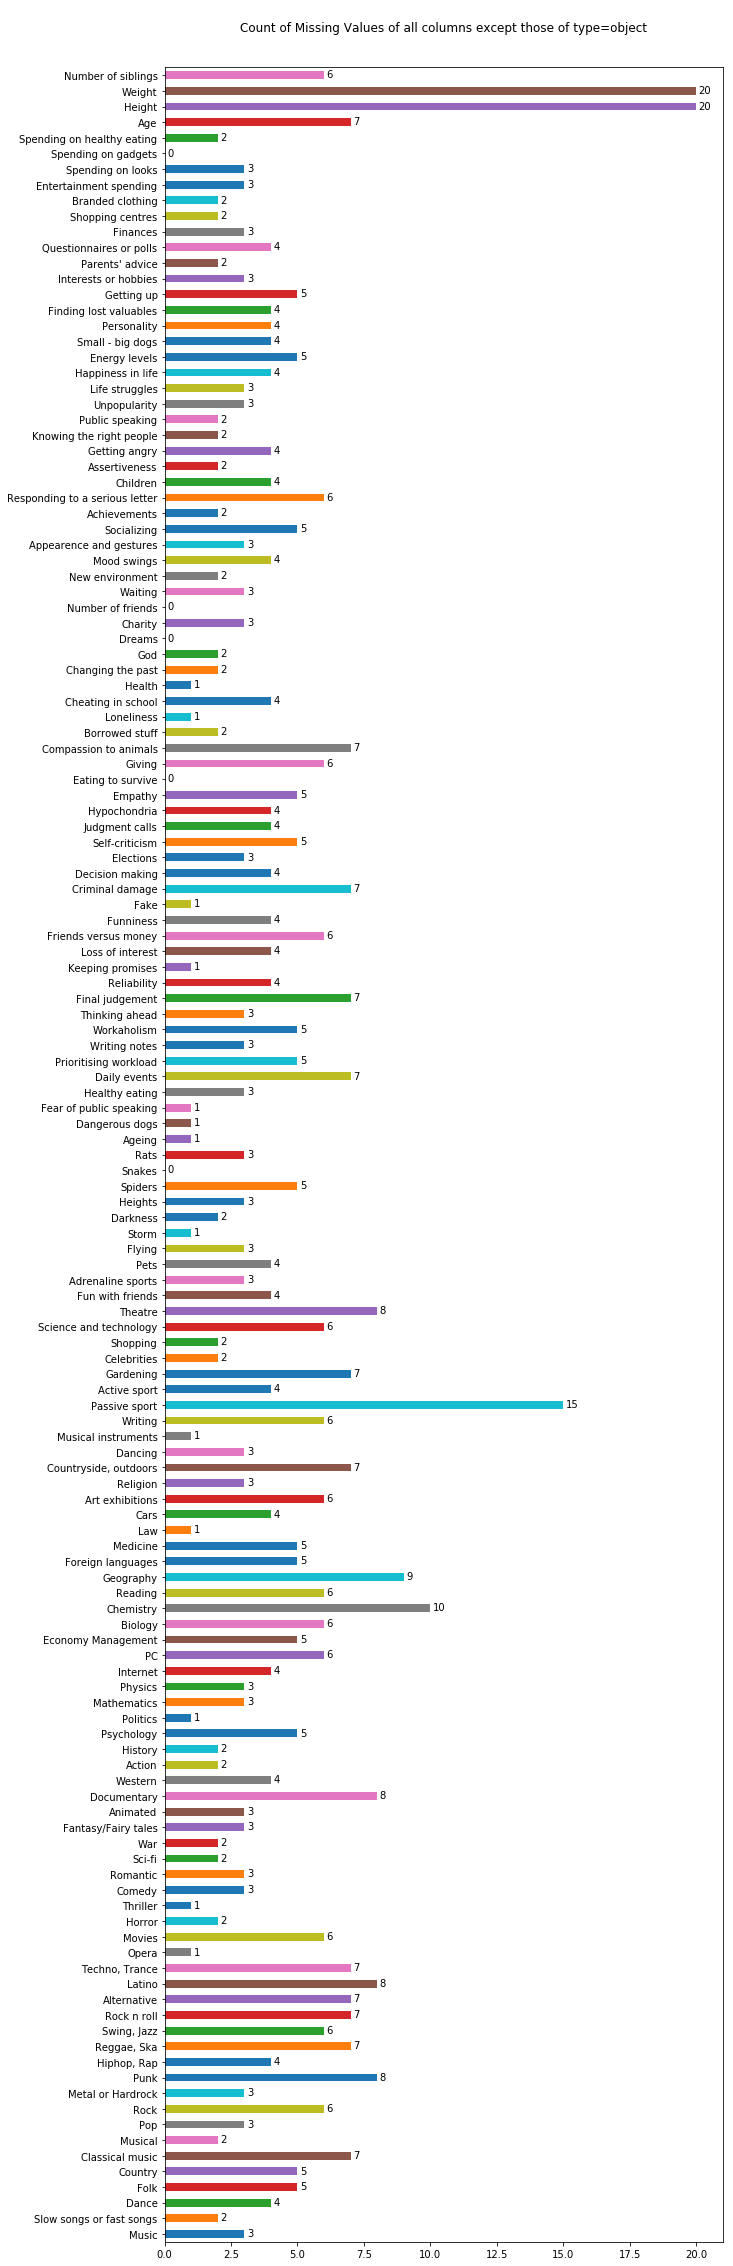

In [79]:
ax = responses.select_dtypes(exclude=['object']).isnull().sum(axis=0).plot(kind='barh',
                                                                           title='\nCount of Missing Values of all columns except those of type=object\n\n',
                                                                           figsize=(10,40))
for p in ax.patches:
    ax.text(p.get_width()+.1, p.get_y()+0.1, p.get_width())

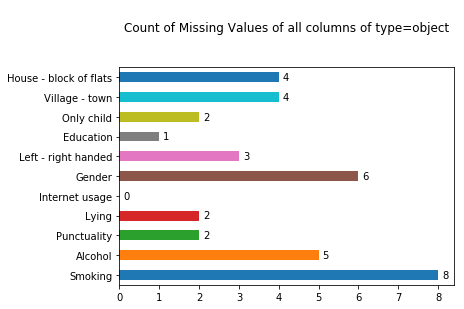

In [80]:
ax = responses.select_dtypes(include=['object']).isnull().sum(axis=0).plot(kind='barh',
                                                                           title='\nCount of Missing Values of all columns of type=object\n\n')
for p in ax.patches:
    ax.text(p.get_width()+.1, p.get_y()+0.1, p.get_width())

**So far we conclude following:**
1. 5 values are missing in our target class & there are missing values in both numeric and categorical data.
2. Missing values can be filled with the mode value of that column.
3. Categorical data must be then converted to numeric data using one-hot encoding technique.

In [81]:
responses = responses.fillna(responses.mode().iloc[0])
for col in responses.columns:
    if responses[col].dtype.kind=='O':
        responses[col]=responses[col].astype('category')
df = pd.get_dummies(responses, columns=list(responses.select_dtypes(include=['category']).columns))
df.head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,Only child_no,Only child_yes,Village - town_city,Village - town_village,House - block of flats_block of flats,House - block of flats_house/bungalow
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,0,0,0,0,1,0,0,1,1,0
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,0,0,0,0,1,0,1,0,1,0
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,0,0,0,1,1,0,1,0,1,0
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,0,0,0,0,0,1,1,0,0,1
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,0,0,0,1,1,0,0,1,0,1


### Separating X & Y and splitting those into Xtr, Ytr, Xte and Yte

In [82]:
Y = df['Empathy']
X = df.drop('Empathy', 1)
print ("Final Shape of Data =", df.shape)

Final Shape of Data = (1010, 173)


In [83]:
# training dataset size = 65% of the total dataset 
# test dataset size = 35% of the total dataset
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.35)

### Method to plot Confusion Matrix

In [84]:
def plotConfusionMatrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=plt.cm.Reds)
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))
    ax.set_xticklabels(['1', '2', '3', '4', '5'])
    ax.set_yticklabels(['1', '2', '3', '4', '5'])
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, cm[i, j], ha="center", va="center")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    fig.tight_layout()
    plt.show()

### Trying different classifiers to find the best among those in terms of accuracy while using default parameters

In [85]:
print('Running different classifiers:')
classifiers = {
    "Baseline Classifier": DummyClassifier(strategy='most_frequent', random_state=1),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=1),
    "Logistic Regression": LogisticRegression(solver='liblinear', multi_class='ovr', random_state=1),
    "SVM - linear kernel": SVC(kernel='linear', random_state=1),
    "SVM - degree 3 polynomial kernel": SVC(kernel='poly', gamma='auto', random_state=1),
    "SVM - rbf kernel": SVC(kernel='rbf', gamma='auto', random_state=1),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=1),
    "AdaBoost Classifier": AdaBoostClassifier(random_state=1),
    "Multi Layer Perceptron Classifier": MLPClassifier(solver='lbfgs', alpha=0.9, max_iter=250, random_state=1),
}

maxScore=0
desiredClassifier = str()
for i in classifiers :
    clf = classifiers[i]
    clf = clf.fit(Xtr, Ytr)
    pred = clf.predict(Xte)
    score = accuracy_score(Yte, pred)
    print ("\tAccuracy score on test data for", i,"is",score)
    if score>maxScore:
        maxScore = score
        desiredClassifier = i
print ("\nThe best performing classifier on this dataset is", desiredClassifier, "while the max. accuracy =", maxScore)

Running different classifiers:
	Accuracy score on test data for Baseline Classifier is 0.3389830508474576
	Accuracy score on test data for Decision Tree Classifier is 0.3192090395480226
	Accuracy score on test data for Logistic Regression is 0.3757062146892655
	Accuracy score on test data for SVM - linear kernel is 0.3502824858757062
	Accuracy score on test data for SVM - degree 3 polynomial kernel is 0.3502824858757062
	Accuracy score on test data for SVM - rbf kernel is 0.3644067796610169
	Accuracy score on test data for Gradient Boosting Classifier is 0.403954802259887
	Accuracy score on test data for AdaBoost Classifier is 0.3813559322033898
	Accuracy score on test data for Multi Layer Perceptron Classifier is 0.3389830508474576

The best performing classifier on this dataset is Gradient Boosting Classifier while the max. accuracy = 0.403954802259887


### Tuning hyperparameters of Gradient Boosting Classifier using GridSearchCV

In [86]:
selected_model = GradientBoostingClassifier(random_state=1)
params = {'max_depth':range(3,8,2),
          'min_samples_split':range(200,401,50),
          'max_features':range(25,31,5),
          'subsample':[0.7,0.75,0.8]}
# Running 4 jobs in parallel
# using 5-fold cross-validation technique

grid_search_model = GridSearchCV(selected_model,param_grid=params,n_jobs=4,iid=True,cv=5)

### Fitting the tuned model, printing the parameters used and saving the trained model

In [87]:
grid_search_model = grid_search_model.fit(Xtr, Ytr)
print("Hyperparameters used =", grid_search_model.best_params_)

Hyperparameters used = {'max_depth': 7, 'max_features': 25, 'min_samples_split': 250, 'subsample': 0.8}


### Dump save the model

In [ ]:
# using Python’s built-in persistence model, Pickle, to save the model
pickle_obj=[grid_search_model, Xte, Yte]
empathy_prediction_model=open('empathy_prediction_model.pkl','wb')
pickle.dump(pickle_obj,empathy_prediction_model)
empathy_prediction_model.close()

### Unpickle to predict

In [88]:
# Unpickle and use the trained model to predict labels on test dataset
empathy_prediction_file=open('empathy_prediction_model.pkl','rb')
pickle_obj=pickle.load(empathy_prediction_file)
trained_clf,Xte,Yte=pickle_obj[0],pickle_obj[1],pickle_obj[2]

### Predicting test labels using the saved model

In [89]:
prediction = trained_clf.predict(Xte)
final_score = accuracy_score(Yte, prediction)
print ("Accuracy score on Test Data is",final_score)

Accuracy score on Test Data is 0.4378531073446328


##################### Classification Report #####################
#################################################################
                         precision    recall  f1-score   support

Not Very Empathetic (1)       0.00      0.00      0.00        18
Not Very Empathetic (2)       0.27      0.09      0.14        33
Not Very Empathetic (3)       0.39      0.37      0.38        71
    Very Empathetic (4)       0.41      0.36      0.38       112
    Very Empathetic (5)       0.48      0.72      0.58       120

              micro avg       0.44      0.44      0.44       354
              macro avg       0.31      0.31      0.29       354
           weighted avg       0.40      0.44      0.40       354

#################################################################


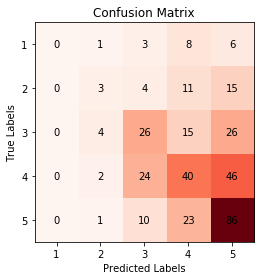

In [91]:
print ("##################### Classification Report #####################")
print ("#################################################################")
print (classification_report(Yte, prediction,target_names=['Not Very Empathetic (1)',
                                                           'Not Very Empathetic (2)',
                                                           'Not Very Empathetic (3)',
                                                           'Very Empathetic (4)',
                                                           'Very Empathetic (5)']))
print ("#################################################################")
cm = confusion_matrix(Yte, prediction)
plotConfusionMatrix(cm)

##### Accuracy score improved from 0.403 to 0.437 after tuning the model selected